# Node classification practice

## Bibliography and references you may find useful
* DiffWire: Inductive Graph Rewiring via the Lovász Bound: https://openreview.net/pdf?id=IXvfIex0mX6f (Here you can find a summary about GNN issues).
* Tutorial of Graph Rewiring: https://youtu.be/AumdG5bazhg (Here you can find a tutorial explaining the principal issues of the graph neural networks and how to solve them).
* Pytorch Geometric: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html (Here you can find the documentation of the library we are going to use. Also, you can find some examples of how to use it and all the dataset available).
### Papers
* Graph representation learning: https://arxiv.org/abs/1709.05584
* Graph Convolutional Networks: https://arxiv.org/abs/1609.02907
* Beyond Homophily in Graph Neural Networks: https://arxiv.org/pdf/2006.11468.pdf
* Graph Attention Networks: https://arxiv.org/pdf/1710.10903.pdf
* Large Scale Learning on Non-Homophilous Graphs: New Benchmarks and Strong Simple Methods: https://arxiv.org/abs/2110.14446

In [2]:
#Libraries we are going to use
# Install required packages.
import os
import torch #Library for deep learning
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
COLLAB_ENV = True
if COLLAB_ENV:
    !pip install 'scipy>=1.8'
    !pip install mycolorpy
import numpy as np #Library for linear algebra
import matplotlib.pyplot as plt #Library for plotting
!pip install networkx #Library for graph
import networkx as nx #Library for graph
from torch_geometric.datasets import Planetoid,WebKB #Library for graph dataset and deep learning on graphs
from torch_geometric.utils import to_dense_adj
import warnings
warnings.filterwarnings("ignore") # Get rid of warnings

/usr/local/python/3.10.4/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1+cu117

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip


### 1. Load data and visualize it

In [3]:
'''
    Load the dataset:
        * root: The root directory where the dataset should be saved.
        * name: The name of the dataset (cora, citeseer or pubmed).
        * transform: A function/transform that takes in an Data object of the dataset and returns a transformed version. The data object will be transformed before every access.
    Returns:
        * Dataset object
'''
dataset = Planetoid(root='/tmp/Cora', name='Cora') # Load the Cora dataset
data = dataset[0] # Get the first graph object (in this case is only one graph, while in Graph classification there are multiple graphs) 
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print()
print(data) # Note that the adjacency matrix is not stored explicitly but in the edge_index attribute.
            # The edge_index attribute is a 2 x E tensor, with each column denoting an edge.
            # The first row denotes the source nodes and the second row the destination nodes of the edges.
            # The nodes are numbered consecutively starting from zero.
            # The features are stored in the x attribute, which is a N x F tensor, with N being the number of nodes and F the number of features per node.
            # The labels are stored in the y attribute, which is a vector of length N, with each entry denoting the class of the corresponding node.
print('===========================================================================================================')
adj = to_dense_adj(data.edge_index)[0] # Convert the sparse adjacency matrix to a dense adjacency matrix
print("Shape of the new adjacency matrix: ",adj.shape)
#Let's get statistics about the graph adjacency matrix
print("Number of nodes: ",adj.shape[0])
print("Number of edges: ",round(adj.sum().item()))
print("Density: ",round((adj.sum()/(adj.shape[0]*adj.shape[0])).item(),4))
print("Maximum node degree: ",round(adj.sum(axis=1).max().item()))
print("Minimum node degree: ",round(adj.sum(axis=1).min().item()))
print("Average node degree: ",round(adj.sum(axis=1).mean().item()))
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print('===========================================================================================================')        



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Shape of the new adjacency matrix:  torch.Size([2708, 2708])
Number of nodes:  2708
Number of edges:  10556
Density:  0.0014
Maximum node degree:  168
Minimum node degree:  1
Average node degree:  4
Has isolated nodes: False
Has self-loops: False
Is undirected: True


### 1.1 Visualize the graph

Data(x=[2485, 1433], edge_index=[2, 10138], y=[2485], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_nodes=2485, num_edges=5069)


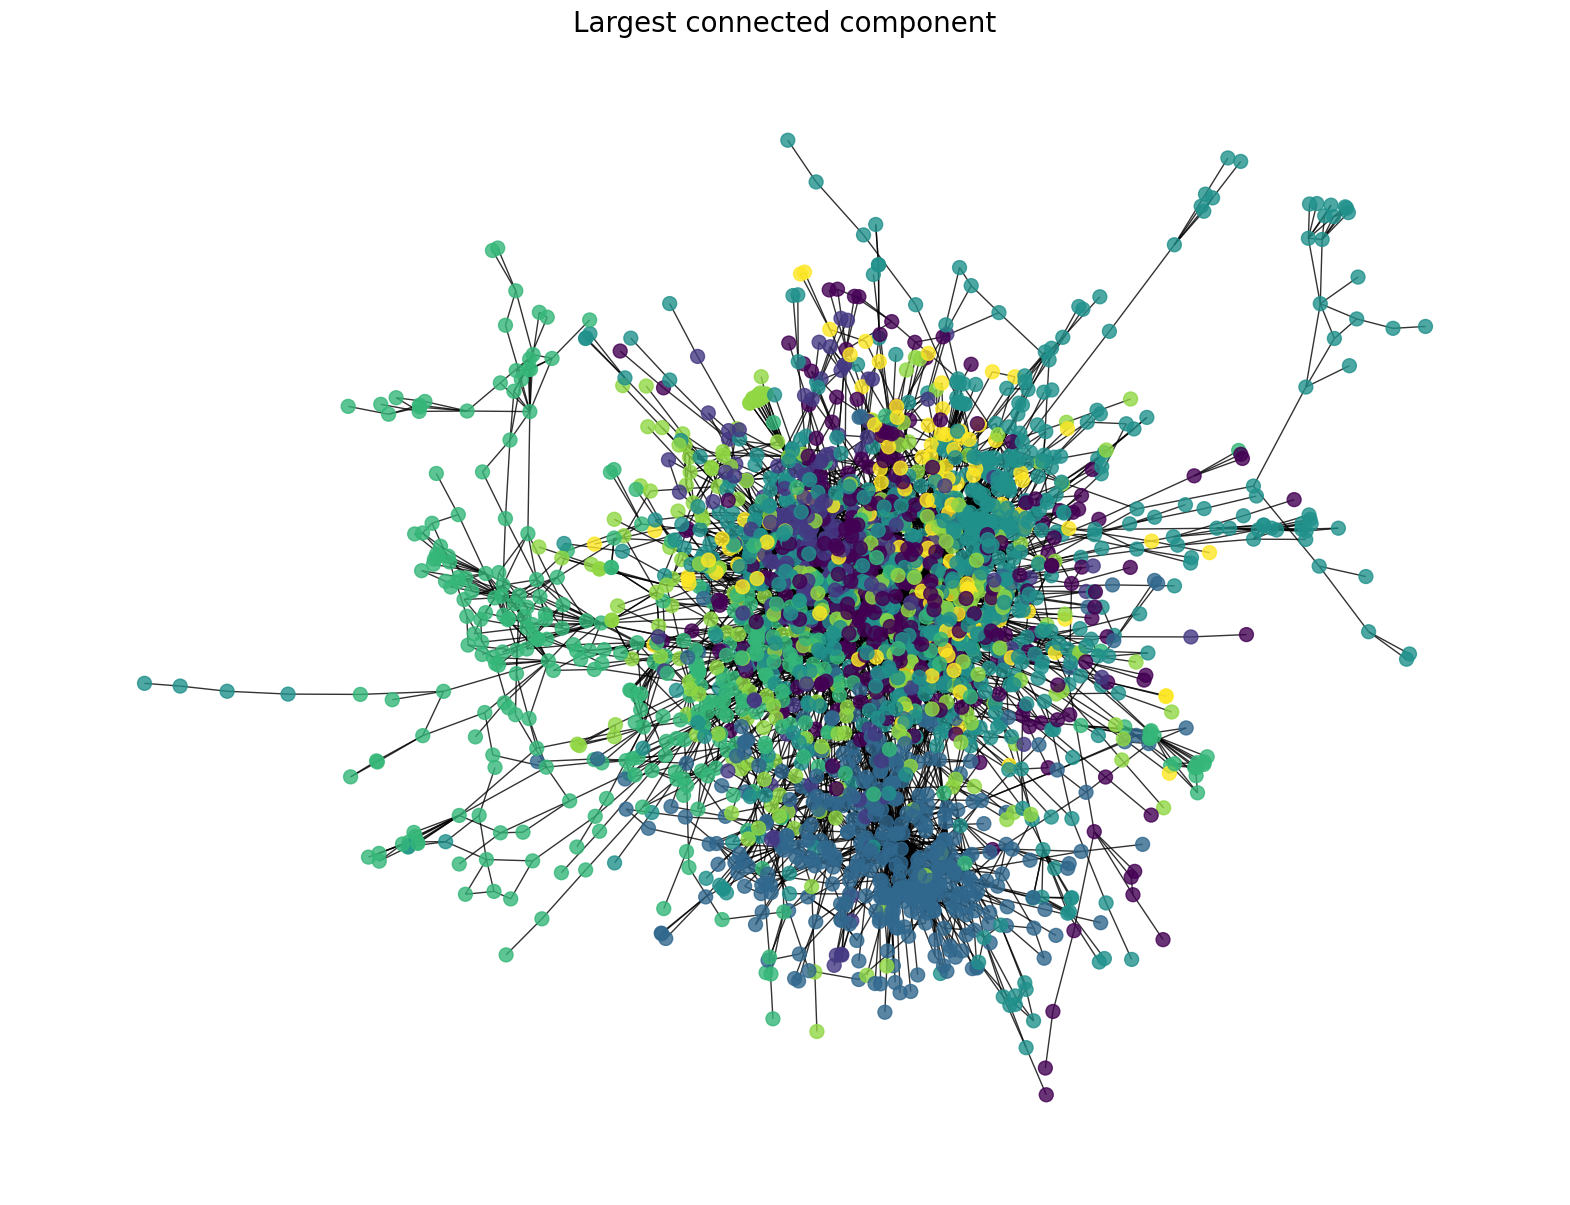

In [4]:
# To visualize the graph we are going to use networkx library, but first we need to convert the graph to networkx format
from torch_geometric.utils import to_networkx
A = to_networkx(data, to_undirected=True) # Convert the graph to networkx format
# Now we are going to get the largest connected component of the graph, because the graph is not connected!
Gcc = sorted(nx.connected_components(A), key=len, reverse=True) # Get the sorted list of connected components
A = A.subgraph(Gcc[0]) # Get the largest connected component 
G = nx.adjacency_matrix(A)
# All the following code is just for plotting the graph, so you can ignore it
# This how we can get the edge_index attribute for the largest connected component
g_tensor = torch.tensor(G.todense())
new_edge_index = g_tensor.nonzero().t().contiguous()
# This is how we create the new data object for the largest connected component
data.x = data.x[list(A.nodes())]
data.y = data.y[list(A.nodes())]
data.edge_index = new_edge_index
data.num_nodes = len(A.nodes())
data.num_edges = len(A.edges())
print(data)
# Now we can plot the graph
A = to_networkx(data, to_undirected=True) # Convert the graph to networkx format
plt.figure(figsize=(20,15))
plt.title('Largest connected component',fontsize=20)
pos = nx.spring_layout(A,seed=12)
#Let's drow the graph, adding borders to the nodes
'''
    Arguments of nx.draw:
        * G: The graph to draw.
        * node_color: The color of the nodes.
        * pos: A dictionary with nodes as keys and positions as values.
        * cmap: A colormap or registered colormap name.
        * node_size: The size of the nodes.
        * edge_color: The color of the edges.
        * width: The width of the edges.
        * with_labels: Whether to draw the node labels.
        * node_shape: The shape of the nodes.
        * alpha: The node transparency.
    Returns:
        * None
'''
nx.draw(A,node_color=data.y,pos= pos, cmap=plt.cm.viridis, node_size=100, edge_color='black',width=1,with_labels=False,node_shape='o',alpha=0.8)
plt.show()

### 1.3 Visualize full graph [Optional]

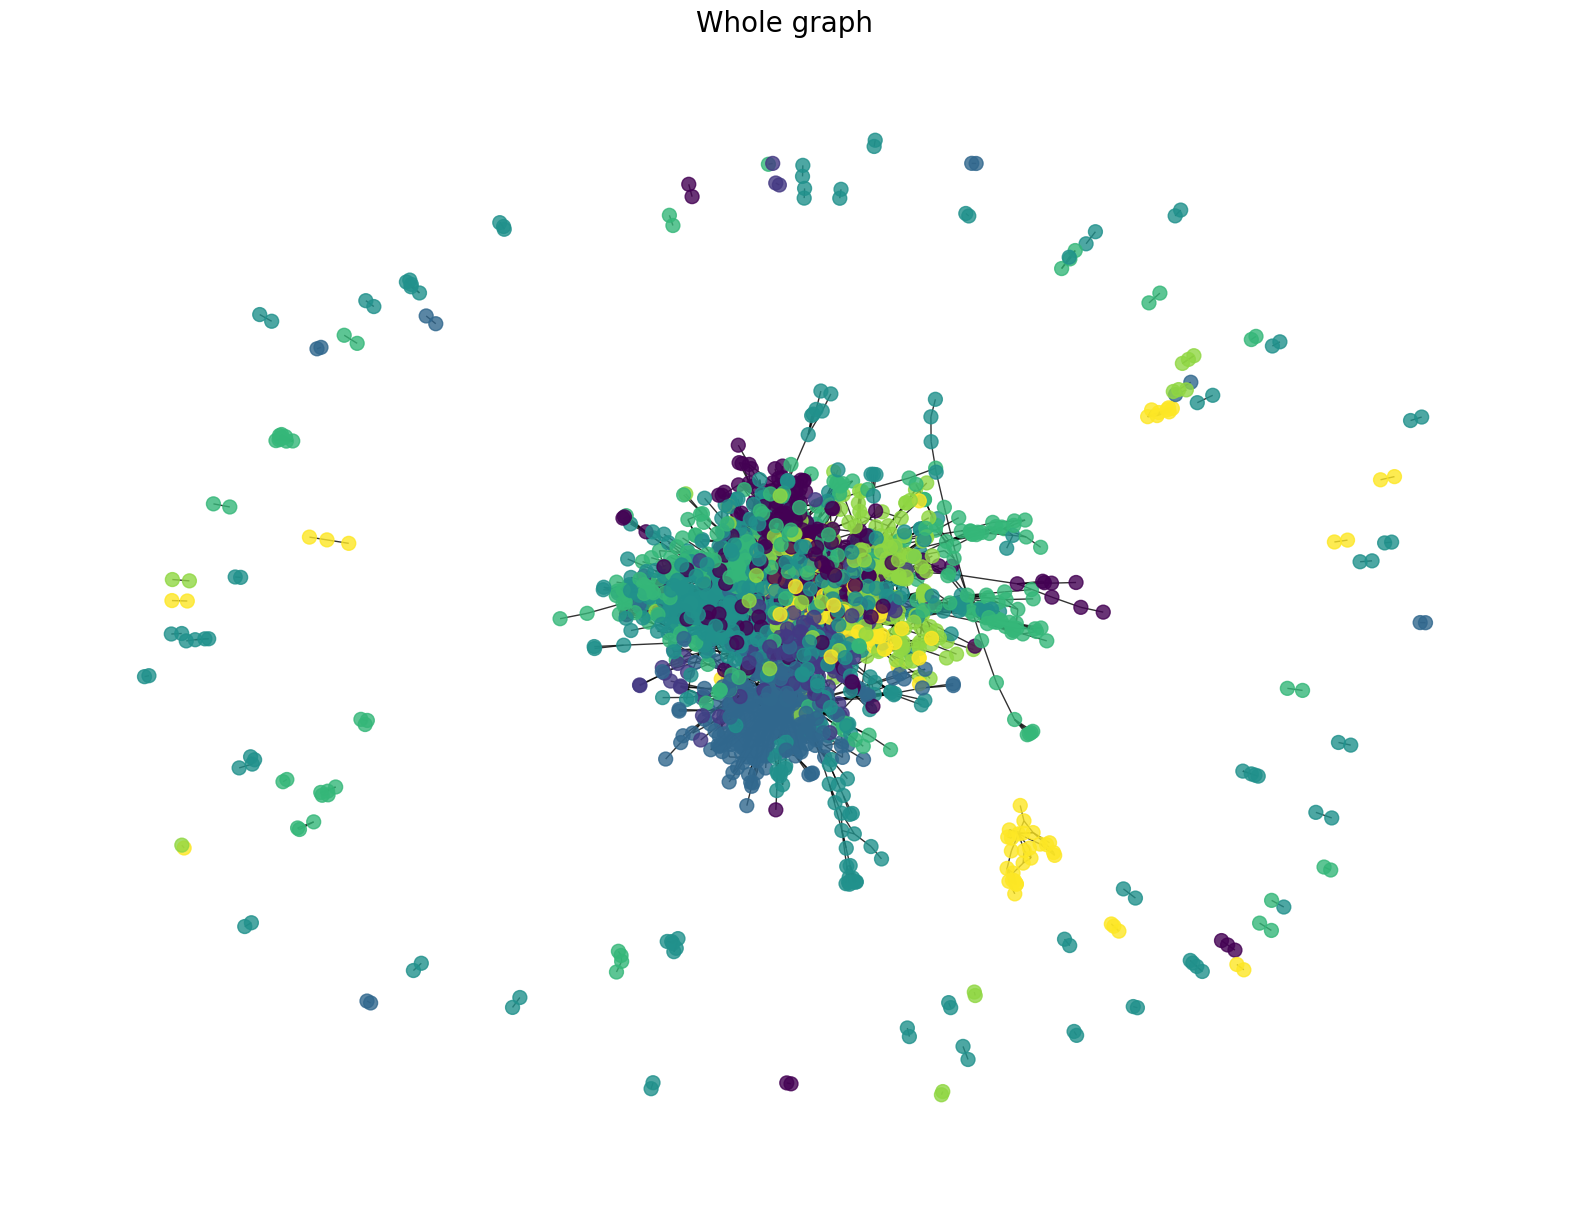

In [5]:
# The same as above but with the whole graph
data = dataset[0]
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(20,15))
plt.title('Whole graph',fontsize=20)
color = data.y
pos = nx.spring_layout(G,seed=12)
nx.draw(G,node_color=color,pos= pos, cmap=plt.cm.viridis, node_size=100, edge_color='black',width=1,with_labels=False,node_shape='o',alpha=0.8)
plt.show()


### 2. Train a GCN model

In this section we will create our model for node classification. We will use a GCN model with 2 hidden layers. The input to the model will be the node features and the output will be the logits for each node in the graph. We will use the cross entropy loss function and the Adam optimizer.

### TASK 0
Here you have to create different models with different Convolutional layers. After that, you have to train them and compare the results in the following section.

#### Utility functions

In [6]:
''' 
    Arguments of train:
        * model: The model to train.
        * data: The data object.
        * optimizer: The optimizer to use.
        * train_mask: The mask of the training nodes.
        * criterion: The loss function to use.
    Returns:
        * loss: The loss of the model.
        * acc: The accuracy of the model.
'''
def train(model, data, optimizer,train_mask,device,criterion = torch.nn.CrossEntropyLoss()):
    model.train()
    optimizer.zero_grad() # Clear gradients.
    #Make sure that we only use the features of the training nodes
    features = torch.zeros(data.x.shape[0],data.x.shape[1]).to(device)
    features[train_mask] = data.x[train_mask]
    # Put the features in the same device as the model
    features = features.to(device)
    out = model(features, data.edge_index) # Perform a single forward pass.
    loss = criterion(out[train_mask], data.y[train_mask]) # Compute the loss solely based on the training nodes.
    pred = out.argmax(dim=1) # Use the class with highest probability.
    acc = pred[train_mask].eq(data.y[train_mask]).sum().item() / train_mask.sum().item() # Derive ratio of correct predictions.
    loss.backward() # Derive gradients.
    optimizer.step() # Update parameters based on gradients.
    return loss,acc
''' 
    Arguments of validation:
        * model: The model to train.
        * data: The data object.
        * val_mask: The mask of the validation nodes.
    Returns:
        * acc: The accuracy of the model.
'''
def validation(model,data,val_mask,device):
    model.eval() # Set model to evaluation mode (e.g. disable dropout)
    #Make sure that we only use the features of the validation nodes
    features = torch.zeros(data.x.shape[0],data.x.shape[1]).to(device)
    features[val_mask] = data.x[val_mask]
    # Put the features in the same device as the model
    features = features.to(device)
    out = model(features, data.edge_index)
    pred = out.argmax(dim=1) # Use the class with highest probability.
    acc = pred[val_mask].eq(data.y[val_mask]).sum().item() / val_mask.sum().item() # Derive ratio of correct predictions.
    return acc
''' 
    Arguments of test:
        * model: The model to train.
        * data: The data object.
        * test_mask: The mask of the test nodes.
    Returns:
        * acc: The accuracy of the model.
'''
def test(model,data,test_mask,device):
    model.eval() # Set model to evaluation mode (e.g. disable dropout)
    #Make sure that we only use the features of the testing nodes
    features = torch.zeros(data.x.shape[0],data.x.shape[1]).to(device)
    features[test_mask] = data.x[test_mask]
    # Put the features in the same device as the model
    features = features.to(device)
    out = model(features, data.edge_index)
    pred = out.argmax(dim=1) # Use the class with highest probability.
    acc = pred[test_mask].eq(data.y[test_mask]).sum().item() / test_mask.sum().item() # Derive ratio of correct predictions.
    return acc

#### Split dataset

In this section we will split the dataset into training, validation and test sets. We will use the training set to train the model, the validation set to tune the hyperparameters and the test set to evaluate the model. We will use two functions for the splits. One function will give as a semi-supervised split where we will have a small number of labeled nodes in the training set and the rest of the nodes will be unlabeled. The other function will give us a fully supervised split where all the nodes in the training set will be labeled.

In [7]:
from sklearn.model_selection import train_test_split
''' 
    Arguments of get_semi_supervised_split:
        * data: The data object.
        * seed: The seed to use for the random split.
    Returns: the train, test and validation masks with an 48%/32%/20%.
        * train_mask: The mask of the training nodes.
        * test_mask: The mask of the test nodes.
        * val_mask: The mask of the validation nodes.
'''
def get_semi_supervised_split(data,seed):
    #We are going to use 48% of the nodes for training, 32% for testing and 20% for validation
    #First we split the nodes in 80% for training and 20% for testing
    #Then we split the training nodes in 48% for training and 32% for validation over the 80% of the nodes
    train_split, test_split = train_test_split(list(range(len(data.y))), test_size=0.20,random_state=seed, shuffle=True)
    train_split, val_split = train_test_split(train_split, test_size=0.40,random_state=seed, shuffle=True)
    
    train_mask = torch.full_like(data.y, False, dtype=bool)
    train_mask[train_split] = True
    
    test_mask = torch.full_like(data.y, False, dtype=bool)
    test_mask[test_split] = True
    
    val_mask = torch.full_like(data.y, False, dtype=bool)
    val_mask[val_split] = True
    
    return train_mask,test_mask,val_mask
''' 
    Arguments of get_supervised_split:
        * data: The data object.
        * seed: The seed to use for the random split.
    Returns: the train, test and validation masks with an 60%/20%/20%.
        * train_mask: The mask of the training nodes.
        * test_mask: The mask of the test nodes.
        * val_mask: The mask of the validation nodes.
'''
def get_supervised_split(data,seed):
    train_split, test_split = train_test_split(list(range(len(data.y))), test_size=0.40,random_state=seed, shuffle=True)
    test_split, val_split = train_test_split(test_split, test_size=0.50,random_state=seed, shuffle=True)
    
    train_mask = torch.full_like(data.y, False, dtype=bool)
    train_mask[train_split] = True
    
    test_mask = torch.full_like(data.y, False, dtype=bool)
    test_mask[test_split] = True
    
    val_mask = torch.full_like(data.y, False, dtype=bool)
    val_mask[val_split] = True
      
    return train_mask, test_mask, val_mask

#### Create the model

In this section we will create our model for node classification. We will use a GCN model with 2 hidden layers. The input to the model will be the node features and the output will be the logits for each node in the graph. We will use the cross entropy loss function and the Adam optimizer.

In [8]:
from torch_geometric.nn import GCNConv
from torch.functional import F
'''
    In PyTorch, you define a model by subclassing torch.nn.Module and defining a forward() method which receives input data and returns output data.
    The forward() method can use other modules defined in the constructor as submodules, and it can use arbitrary operators on Tensors, including loops and conditional statements.
    This approach is very flexible, and you can use it to define models of arbitrary complexity.
'''
class GCN(torch.nn.Module):
    '''
        Arguments of __init__:
            * hidden_channels: The number of hidden units.
            * dataset.num_features: The number of input features.
            * dataset.num_classes: The number of output classes.
        Returns:
            * self.conv1: The first GCN layer.
            * self.conv2: The second GCN layer.
    '''
    def __init__(self,hidden_channels = 16):
        super(GCN, self).__init__()
        # 2-layer GCN
        self.conv1 = GCNConv(dataset.num_features, hidden_channels) # 32 hidden units
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes) # dataset.num_classes output units
    '''
        Arguments of forward:
            * x: The input features.
            * edge_index: The edge indices.
        Returns:
            * F.softmax(x, dim=1): The output of the model.
    '''
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index)) # ReLU activation
        x = F.dropout(x,p=0.5, training=self.training) # Dropout: 50% of the nodes are randomly dropped out during training
        x = self.conv2(x, edge_index)
        return x.softmax(dim=1) # Log softmax activation
print(GCN())    

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [9]:
#define una capa SimpleConv()
#SimpleConv(32, 16)
#SimpleConv(16, 7)

from torch_geometric.nn import GATConv
from torch.functional import F

class GAT(torch.nn.Module):
    
        def __init__(self,hidden_channels = 16):
            super(GAT, self).__init__()
            # 2-layer GCN
            self.conv1 = GATConv(dataset.num_features, hidden_channels) # 32 hidden units
            self.conv2 = GATConv(hidden_channels, dataset.num_classes) # dataset.num_classes output units
    
        def forward(self, x, edge_index):
            x = F.relu(self.conv1(x, edge_index)) # ReLU activation
            x = F.dropout(x,p=0.5, training=self.training) # Dropout: 50% of the nodes are randomly dropped out during training
            x = self.conv2(x, edge_index)
            return x.softmax(dim=1) # Log softmax activation

print(GAT())


GAT(
  (conv1): GATConv(1433, 16, heads=1)
  (conv2): GATConv(16, 7, heads=1)
)


In [10]:
#GraphConv(32, 16)
#GraphConv(16, 7)

from torch_geometric.nn import SAGEConv
from torch.functional import F

class SAGE(torch.nn.Module):
        
            def __init__(self,hidden_channels = 16):
                super(SAGE, self).__init__()
                # 2-layer GCN
                self.conv1 = SAGEConv(dataset.num_features, hidden_channels) # 32 hidden units
                self.conv2 = SAGEConv(hidden_channels, dataset.num_classes) # dataset.num_classes output units
        
            def forward(self, x, edge_index):
                x = F.relu(self.conv1(x, edge_index)) # ReLU activation
                x = F.dropout(x,p=0.5, training=self.training) # Dropout: 50% of the nodes are randomly dropped out during training
                x = self.conv2(x, edge_index)
                return x.softmax(dim=1) # Log softmax activation

print(SAGE())


SAGE(
  (conv1): SAGEConv(1433, 16, aggr=mean)
  (conv2): SAGEConv(16, 7, aggr=mean)
)


In [11]:
from torch_geometric.nn import GINConv
from torch.functional import F

class GIN(torch.nn.Module):
        
            def __init__(self,hidden_channels = 16):
                super(GIN, self).__init__()
                # 2-layer GCN
                self.conv1 = GINConv(torch.nn.Linear(dataset.num_features, hidden_channels)) # 32 hidden units
                self.conv2 = GINConv(torch.nn.Linear(hidden_channels, dataset.num_classes)) # dataset.num_classes output units
        
            def forward(self, x, edge_index):
                x = F.relu(self.conv1(x, edge_index)) # ReLU activation
                x = F.dropout(x,p=0.5, training=self.training) # Dropout: 50% of the nodes are randomly dropped out during training
                x = self.conv2(x, edge_index)
                return x.softmax(dim=1) # Log softmax activation

print(GIN())

            

GIN(
  (conv1): GINConv(nn=Linear(in_features=1433, out_features=16, bias=True))
  (conv2): GINConv(nn=Linear(in_features=16, out_features=7, bias=True))
)


In [14]:
from torch.nn import Linear
# Same as GCN but with Linear layers instead of GCNConv layers. If we use MLP as a model, we can't take into account the graph STRUCTURE.
class MLP(torch.nn.Module):
    def __init__(self,hidden_channels = 16):
        super(MLP, self).__init__()
        # 2-layer GCN
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # edge_index is not used
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x.softmax(dim=1)
print(MLP())

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Using the above models as templates, **create as many cells as models**. 

#### Train the models

In [22]:
# Seeds for the random split. This allows us to reproduce the results.
RandList = [12345, 423456, 643451, 543452, 743456, 4734510, 654321, 124321, 945321, 784328]
# This allows us to run the code on the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Here you can add models to train  and test (include your own models)
#in the list of model
models = [SAGE(), GCN(), MLP(), GIN(), GAT()] 
global_results = []
global_best_models = []
for j in range(len(models)):
    ExperimentResult = []
    best_model = None
    print(data)
    for i in range(10):
        print("Random State", RandList[i]," in the iteration",i)
        train_mask,test_mask,val_mask = get_semi_supervised_split(data.cpu(), RandList[i])
        #train_mask,test_mask,val_mask = get_supervised_split(data.cpu(), RandList[i])
        data = data.to(device)
        model = models[j].to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        for epoch in range(1, 101):
            loss, acc_train = train(model,data,optimizer,train_mask.to(device),device=device)
            acc_validation = validation(model,data,val_mask.to(device),device=device)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Val Acc: {:.5f}'.format(epoch, loss, acc_train, acc_validation))
        acc = test(model,data,test_mask.to(device),device=device)
        print('Test Accuracy: {:.5f}'.format(acc))
        # Save the best model over the 10 runs
        if best_model is None or acc > best_model[1]:
            best_model = [model, acc]
        ExperimentResult.append(acc)
    print(models[j].__class__.__name__) # Name of the model
    print('{} +- {}'.format(np.mean(ExperimentResult)*100, np.std(ExperimentResult)*100))
    global_results.append(ExperimentResult.copy())
    global_best_models.append(best_model.copy())



cpu
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Random State 12345  in the iteration 0
Epoch: 001, Loss: 1.95050, Train Acc: 0.09084, Val Acc: 0.08535
Epoch: 002, Loss: 1.93824, Train Acc: 0.17629, Val Acc: 0.35525
Epoch: 003, Loss: 1.91373, Train Acc: 0.44573, Val Acc: 0.51442
Epoch: 004, Loss: 1.87970, Train Acc: 0.50038, Val Acc: 0.52595
Epoch: 005, Loss: 1.84536, Train Acc: 0.49731, Val Acc: 0.52595
Epoch: 006, Loss: 1.79622, Train Acc: 0.51424, Val Acc: 0.51672
Epoch: 007, Loss: 1.74947, Train Acc: 0.52810, Val Acc: 0.51788
Epoch: 008, Loss: 1.72154, Train Acc: 0.52117, Val Acc: 0.53518
Epoch: 009, Loss: 1.69027, Train Acc: 0.53657, Val Acc: 0.54787
Epoch: 010, Loss: 1.66130, Train Acc: 0.56120, Val Acc: 0.55709
Epoch: 011, Loss: 1.63374, Train Acc: 0.56582, Val Acc: 0.56632
Epoch: 012, Loss: 1.60992, Train Acc: 0.58891, Val Acc: 0.58016
Epoch: 013, Loss: 1.59079, Train Acc: 0.61740, Val Acc: 0.58939
Epoch: 014, Loss:

#### Visualize the results and the embedding

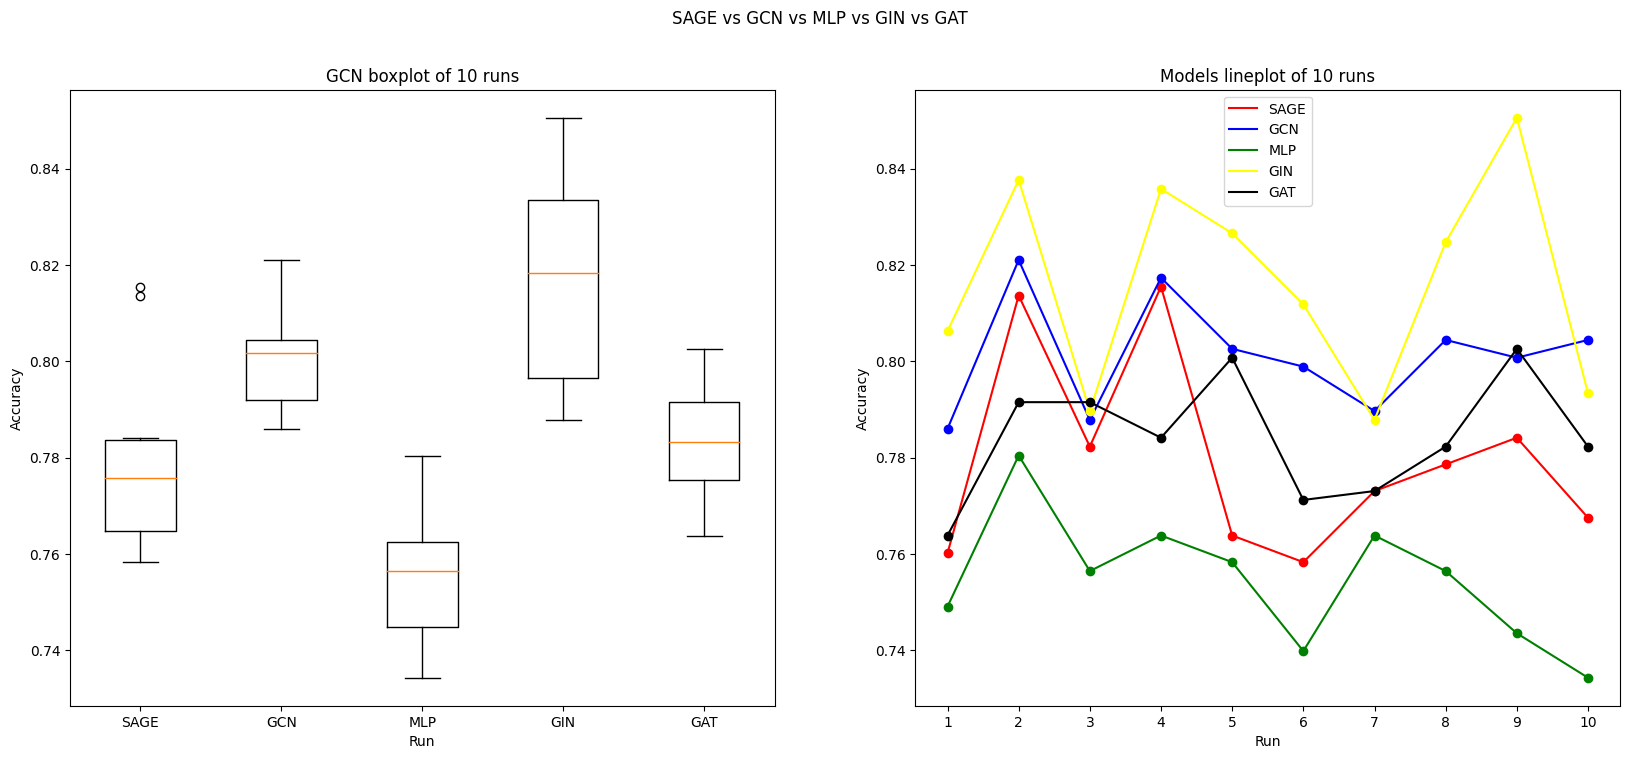

In [30]:
#[SAGE(), GCN(), MLP(), GIN(), GAT()] 
# fig,axs = plt.subplots(1,5,figsize=(20,8))
# axs[0].set_title('GCN boxplot of 10 runs')
# axs[0].boxplot(global_results,labels=['GCN','MLP'])
# axs[0].set_xlabel('Run')
# axs[0].set_ylabel('Accuracy')
# '''
# axs[0,1].set_title('GCN histogram of 10 runs')
# axs[0,1].bar(range(1,11),ExperimentResult)
# axs[0,1].set_xticks(range(1,11))
# axs[0,1].set_xlabel('Run')
# axs[0,1].set_ylabel('Accuracy')
# axs[0,1].plot(range(1,11),ExperimentResult,'ro',color='red')
# axs[0,1].plot(range(1,11),ExperimentResult,color='red',label='Accuracy')'''

# axs[1].set_title('Models lineplot of 10 runs')
# axs[1].plot(range(1,11),global_results[0],'ro',color='red')
# axs[1].plot(range(1,11),global_results[0],color='red',label='GCN')

# axs[1].plot(range(1,11),global_results[1],'ro',color='blue')
# axs[1].plot(range(1,11),global_results[1],color='blue',label='MLP')

# axs[1].set_xticks(range(1,11))
# axs[1].set_xlabel('Run')
# axs[1].set_ylabel('Accuracy')
# axs[1].legend()
# fig.suptitle('GCN vs MLP')
# fig.show()

#realiza la anterior visualización para [SAGE(), GCN(), MLP(), GIN(), GAT()] 

fig,axs = plt.subplots(1,2,figsize=(20,8))
axs[0].set_title('GCN boxplot of 10 runs')
axs[0].boxplot(global_results,labels=['SAGE','GCN','MLP','GIN','GAT'])
axs[0].set_xlabel('Run')
axs[0].set_ylabel('Accuracy')

axs[1].set_title('Models lineplot of 10 runs')
axs[1].plot(range(1,11),global_results[0],'ro',color='red')
axs[1].plot(range(1,11),global_results[0],color='red',label='SAGE')

axs[1].plot(range(1,11),global_results[1],'ro',color='blue')
axs[1].plot(range(1,11),global_results[1],color='blue',label='GCN')

axs[1].plot(range(1,11),global_results[2],'ro',color='green')
axs[1].plot(range(1,11),global_results[2],color='green',label='MLP')

axs[1].plot(range(1,11),global_results[3],'ro',color='yellow')
axs[1].plot(range(1,11),global_results[3],color='yellow',label='GIN')

axs[1].plot(range(1,11),global_results[4],'ro',color='black')
axs[1].plot(range(1,11),global_results[4],color='black',label='GAT')

axs[1].set_xticks(range(1,11))
axs[1].set_xlabel('Run')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
fig.suptitle('SAGE vs GCN vs MLP vs GIN vs GAT')
fig.show()


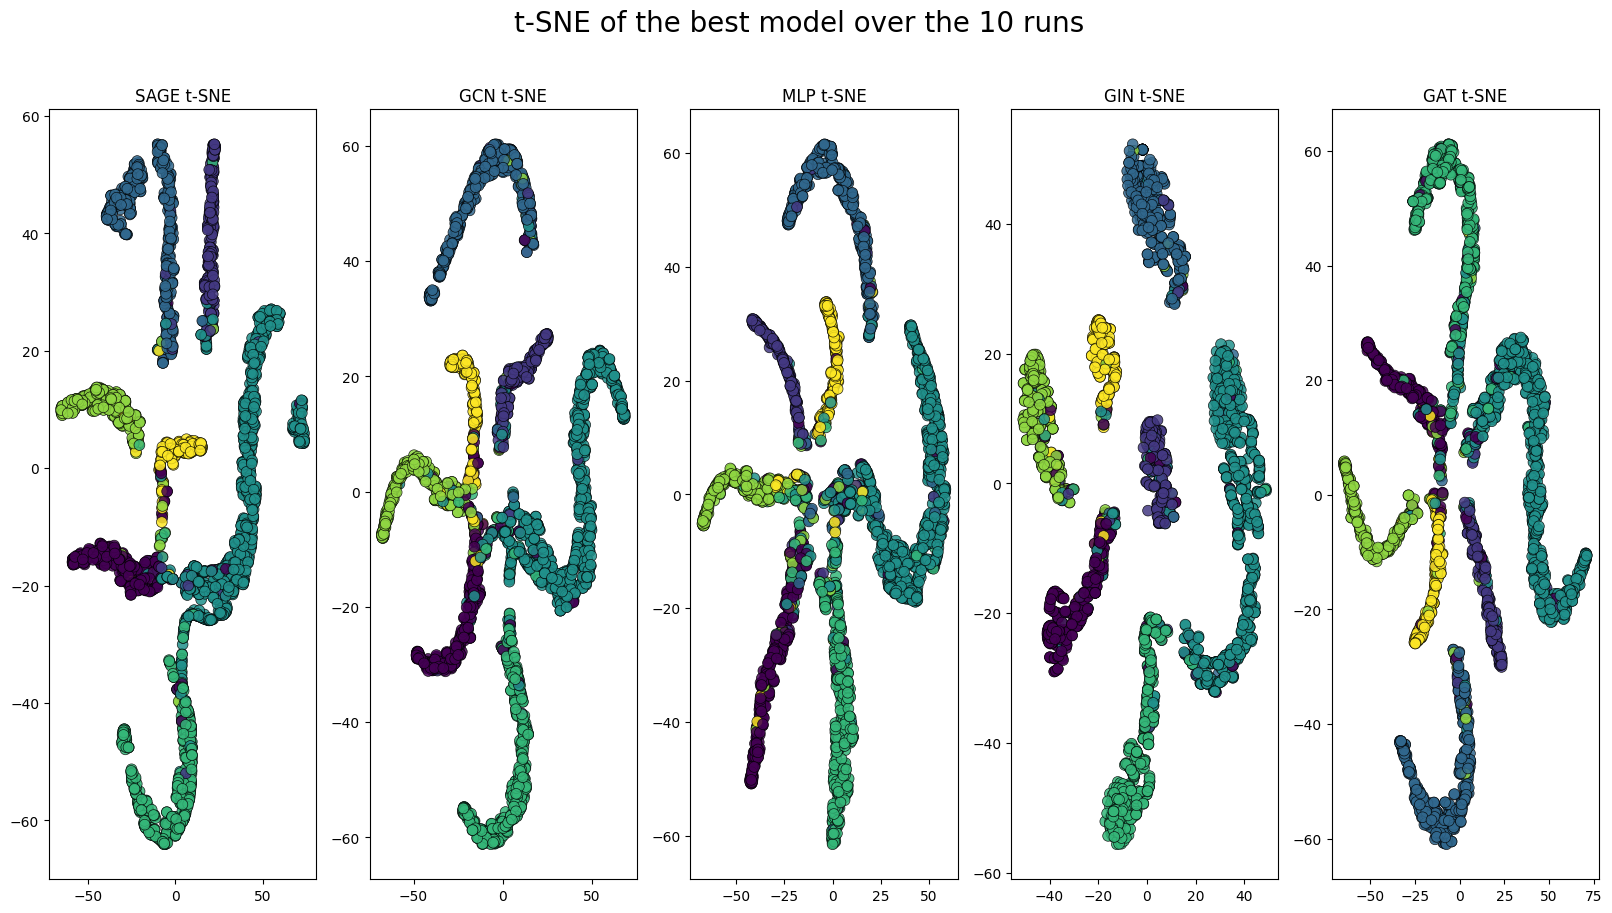

In [33]:
from sklearn.manifold import TSNE
# Let's see the embedding of the best model over the 10 runs
# First model is GCN, second model is MLP
# GCN
#out_gcn = global_best_models[0][0](data.x, data.edge_index) # Get the output of the model with the entire dataset
'''
    Arguments of TSNE:
        * n_components: The dimension of the embedded space.
        * random_state: The seed to use for the t-SNE algorithm.
    Returns:
        * tsne_obj: The t-SNE embedding of the nodes.
'''
# tsne = TSNE(n_components=2, random_state=12345)
# tsne_gcn_results = tsne.fit_transform(out_gcn.detach().cpu().numpy())
# # MLP
# out_mlp = global_best_models[1][0](data.x, data.edge_index) # Get the output of the model with the entire dataset
# tsne = TSNE(n_components=2, random_state=12345)
# tsne_mlp_results = tsne.fit_transform(out_mlp.detach().cpu().numpy())
# # Plot the results
# fig,axs = plt.subplots(1,2,figsize=(20,10))
# axs[0].set_title('GCN t-SNE')
# axs[0].scatter(tsne_gcn_results[:,0],tsne_gcn_results[:,1],c=data.y.cpu(),cmap='viridis',s=60,alpha=0.85,edgecolors='black',linewidths=0.5)

# axs[1].set_title('MLP t-SNE')
# axs[1].scatter(tsne_mlp_results[:,0],tsne_mlp_results[:,1],c=data.y.cpu(),cmap='viridis',s=60,alpha=0.85,edgecolors='black',linewidths=0.5)

# fig.suptitle('t-SNE of the best model over the 10 runs',fontsize=20)
# fig.show()

# Realiza el anterior código para [SAGE(), GCN(), MLP(), GIN(), GAT()]

out_sage = global_best_models[0][0](data.x, data.edge_index) # Get the output of the model with the entire dataset
tsne = TSNE(n_components=2, random_state=12345)
tsne_sage_results = tsne.fit_transform(out_sage.detach().cpu().numpy())

out_gcn = global_best_models[1][0](data.x, data.edge_index) # Get the output of the model with the entire dataset
tsne = TSNE(n_components=2, random_state=12345)
tsne_gcn_results = tsne.fit_transform(out_gcn.detach().cpu().numpy())

out_mlp = global_best_models[2][0](data.x, data.edge_index) # Get the output of the model with the entire dataset
tsne = TSNE(n_components=2, random_state=12345)
tsne_mlp_results = tsne.fit_transform(out_mlp.detach().cpu().numpy())

out_gin = global_best_models[3][0](data.x, data.edge_index) # Get the output of the model with the entire dataset
tsne = TSNE(n_components=2, random_state=12345)
tsne_gin_results = tsne.fit_transform(out_gin.detach().cpu().numpy())

out_gat = global_best_models[4][0](data.x, data.edge_index) # Get the output of the model with the entire dataset
tsne = TSNE(n_components=2, random_state=12345)
tsne_gat_results = tsne.fit_transform(out_gat.detach().cpu().numpy())

# Plot the results
fig,axs = plt.subplots(1,5,figsize=(20,10))
axs[0].set_title('SAGE t-SNE')
axs[0].scatter(tsne_sage_results[:,0],tsne_sage_results[:,1],c=data.y.cpu(),cmap='viridis',s=60,alpha=0.85,edgecolors='black',linewidths=0.5)

axs[1].set_title('GCN t-SNE')
axs[1].scatter(tsne_gcn_results[:,0],tsne_gcn_results[:,1],c=data.y.cpu(),cmap='viridis',s=60,alpha=0.85,edgecolors='black',linewidths=0.5)

axs[2].set_title('MLP t-SNE')
axs[2].scatter(tsne_mlp_results[:,0],tsne_mlp_results[:,1],c=data.y.cpu(),cmap='viridis',s=60,alpha=0.85,edgecolors='black',linewidths=0.5)

axs[3].set_title('GIN t-SNE')
axs[3].scatter(tsne_gin_results[:,0],tsne_gin_results[:,1],c=data.y.cpu(),cmap='viridis',s=60,alpha=0.85,edgecolors='black',linewidths=0.5)

axs[4].set_title('GAT t-SNE')
axs[4].scatter(tsne_gat_results[:,0],tsne_gat_results[:,1],c=data.y.cpu(),cmap='viridis',s=60,alpha=0.85,edgecolors='black',linewidths=0.5)

fig.suptitle('t-SNE of the best model over the 10 runs',fontsize=20)
fig.show()


### 3.1 Report

In this section we will report the results of the model. We will report the accuracy, precision, recall and F1 score for the model. We will also visualize the confusion matrix for the model using the scikit-learn library to report the results. After all, we will put the results in a markdown cell.

#### Report the results

In [36]:
# Report the best model over the 10 runs using the test set and sklearn classification report
from sklearn.metrics import classification_report
# print('GCN')
# print(classification_report(data.y[test_mask].cpu(), global_best_models[0][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))
# print('========================================================================')
# print('MLP')
# print(classification_report(data.y[test_mask].cpu(), global_best_models[1][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

#Realiza el código anterior para [SAGE(), GCN(), MLP(), GIN(), GAT()]

print('SAGE')
print(classification_report(data.y[test_mask].cpu(), global_best_models[0][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))
print('========================================================================')
print('GCN')
print(classification_report(data.y[test_mask].cpu(), global_best_models[1][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))
print('========================================================================')
print('MLP')
print(classification_report(data.y[test_mask].cpu(), global_best_models[2][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))
print('========================================================================')
print('GIN')
print(classification_report(data.y[test_mask].cpu(), global_best_models[3][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))
print('========================================================================')
print('GAT')
print(classification_report(data.y[test_mask].cpu(), global_best_models[4][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))


SAGE
              precision    recall  f1-score   support

           0       0.73      0.84      0.78        61
           1       0.69      0.76      0.72        33
           2       0.91      0.99      0.95        91
           3       0.94      0.87      0.90       185
           4       0.86      0.84      0.85        83
           5       0.86      0.88      0.87        48
           6       0.86      0.73      0.79        41

    accuracy                           0.87       542
   macro avg       0.84      0.84      0.84       542
weighted avg       0.87      0.87      0.87       542

GCN
              precision    recall  f1-score   support

           0       0.74      0.84      0.78        61
           1       0.74      0.85      0.79        33
           2       0.94      0.99      0.96        91
           3       0.94      0.89      0.91       185
           4       0.88      0.83      0.86        83
           5       0.81      0.88      0.84        48
           6   

#### Task 1
Explain the metrics used in the report:
- Accuracy:
- Precision:
- Recall:
- F1 score:

Why is it important to report all these metrics? Did you notice that the accuracy is not the best metric to report? Why?

#### Confusion matrix

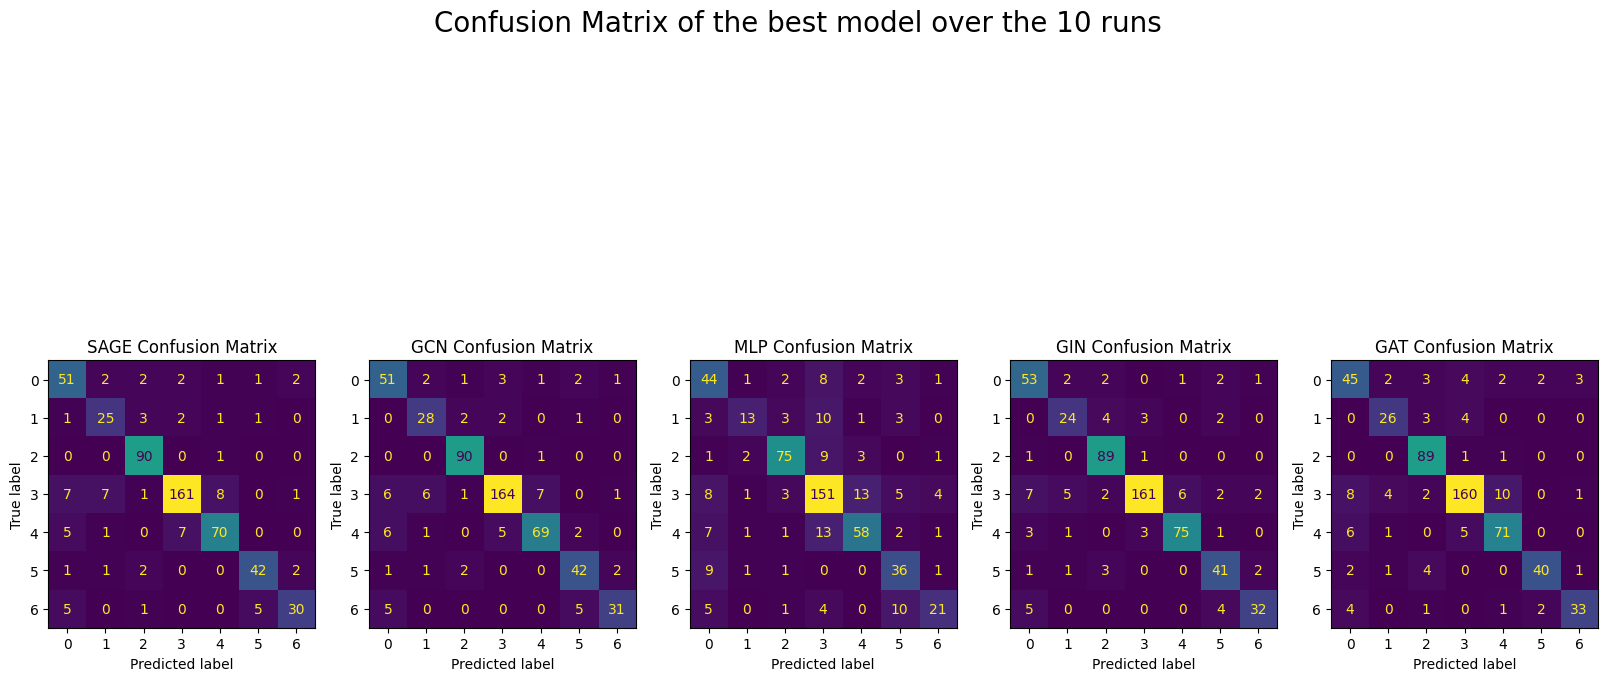

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# conf_matrix_gcn = confusion_matrix(data.y[test_mask].cpu(), global_best_models[0][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
# conf_matrix_mlp = confusion_matrix(data.y[test_mask].cpu(), global_best_models[1][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
# disp_gcn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gcn, display_labels=data.y.unique().cpu().numpy())
# disp_mlp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_mlp, display_labels=data.y.unique().cpu().numpy())
# fig,axs = plt.subplots(1,2,figsize=(20,10))

# disp_gcn.plot(ax=axs[0])
# disp_gcn.ax_.set_title('GCN Confusion Matrix')
# disp_gcn.ax_.set_xlabel('Predicted label')
# disp_gcn.ax_.set_ylabel('True label')
# disp_gcn.im_.colorbar.remove()

# disp_mlp.plot(ax=axs[1])
# disp_mlp.ax_.set_title('MLP Confusion Matrix')
# disp_mlp.ax_.set_xlabel('Predicted label')
# disp_mlp.ax_.set_ylabel('True label')
# disp_mlp.im_.colorbar.remove()

# fig.suptitle('Confusion Matrix of the best model over the 10 runs',fontsize=20)
# fig.show()

#Realiza el código anterior para [SAGE(), GCN(), MLP(), GIN(), GAT()]

conf_matrix_sage = confusion_matrix(data.y[test_mask].cpu(), global_best_models[0][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
conf_matrix_gcn = confusion_matrix(data.y[test_mask].cpu(), global_best_models[1][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
conf_matrix_mlp = confusion_matrix(data.y[test_mask].cpu(), global_best_models[2][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
conf_matrix_gin = confusion_matrix(data.y[test_mask].cpu(), global_best_models[3][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
conf_matrix_gat = confusion_matrix(data.y[test_mask].cpu(), global_best_models[4][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())

disp_sage = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_sage, display_labels=data.y.unique().cpu().numpy())
disp_gcn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gcn, display_labels=data.y.unique().cpu().numpy())
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_mlp, display_labels=data.y.unique().cpu().numpy())
disp_gin = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gin, display_labels=data.y.unique().cpu().numpy())
disp_gat = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gat, display_labels=data.y.unique().cpu().numpy())

fig,axs = plt.subplots(1,5,figsize=(20,10))

disp_sage.plot(ax=axs[0])
disp_sage.ax_.set_title('SAGE Confusion Matrix')
disp_sage.ax_.set_xlabel('Predicted label')
disp_sage.ax_.set_ylabel('True label')
disp_sage.im_.colorbar.remove()

disp_gcn.plot(ax=axs[1])
disp_gcn.ax_.set_title('GCN Confusion Matrix')
disp_gcn.ax_.set_xlabel('Predicted label')
disp_gcn.ax_.set_ylabel('True label')
disp_gcn.im_.colorbar.remove()

disp_mlp.plot(ax=axs[2])
disp_mlp.ax_.set_title('MLP Confusion Matrix')
disp_mlp.ax_.set_xlabel('Predicted label')
disp_mlp.ax_.set_ylabel('True label')
disp_mlp.im_.colorbar.remove()

disp_gin.plot(ax=axs[3])
disp_gin.ax_.set_title('GIN Confusion Matrix')
disp_gin.ax_.set_xlabel('Predicted label')
disp_gin.ax_.set_ylabel('True label')
disp_gin.im_.colorbar.remove()

disp_gat.plot(ax=axs[4])
disp_gat.ax_.set_title('GAT Confusion Matrix')
disp_gat.ax_.set_xlabel('Predicted label')
disp_gat.ax_.set_ylabel('True label')
disp_gat.im_.colorbar.remove()

fig.suptitle('Confusion Matrix of the best model over the 10 runs',fontsize=20)
fig.show()


#### Report the results in a markdown cell
Put your results in this table:

|  | Cora | Citeseer | Actor | Chamaleon | Squirrel | Wisconsin | Squirrel | Cornell | Texas |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| MLP | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ |
| GCN | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ |
| ... | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ |
| ... | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ |
| ... | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ | 0.00 $\pm{0.00}$ |


### TASK 3
Make a summary of the architecture of the model you used. What are the parameters of the model? What is the number of parameters of the model? What is the number of trainable parameters of the model? Why they perform differently? What happens if you add to much layers of GNNs? During your summary, you can cite the different papers you used to implement your model.
### TASK 4
During the experiments, you have used different datasets with different **Heterophily** and **Homophily**:

1.   Explain what is the Heterophily and Homophily. Implement a function so that given a graph/dataset you obtain the edge-homophility.  
2.   What is the impact of the Heterophily and Homophily on the performance of the model?
3.   Include the edge-homophily of each dataset in the table above. Explain your conclusions on behalf of the edge-homophily. 
